### aim: 

### date: 

In [204]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [205]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [206]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [207]:
scendict = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

In [208]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear/nemo_bc370o_1y_1989_moc.nc')
w

<xarray.Dataset>
Dimensions:       (depthw: 75, time_counter: 12, x: 1, y: 332)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1989-01-31 ... 1989-12-31
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
  * depthw        (depthw) float32 -0.0 -1.0239066 ... -5596.249 -5800.0
Dimensions without coordinates: x, y
Data variables:
    zomsfglo      (time_counter, depthw, y, x) float64 ...
Attributes:
    made in:  overturning/makeyearfiles_overturning.ipynb
    desc:     concatenate monthly overturning output into yearly and give goo...

In [211]:
def make_yearfiles_ukesm(yrst, yren, tscen):
    print(f'SCENARIO {tscen}')
    dslist = []
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear/'
    
    for y in range(yrst,yren):
        if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
            tstr = scendict['1A']['hist_str']
        elif y<2015:
            tstr = scendict[tscen]['hist_str']

        else:
            tstr = scendict[tscen]['fut_str']
        try:

            td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_moc.nc')
            dslist.append(td[0])
            if (len(td) != 1):
                print(f'SCENARIO {tscen}, {y}, something missing')

        except:
            pass

    return dslist

def get_max_overturning(overturning_xarray):

    q= overturning_xarray.where(overturning_xarray==overturning_xarray.max(), drop=True).squeeze()
    lat = q.nav_lat.values
    depth = (q.depthw.values)
    ot = (q.values)
    
    return lat, depth, ot

def get_overturning_ts(mfdataset, yrst, yren):

    times = pd.date_range(f"{yrst}/01/01",f"{yren+1}/01/01",freq='YS',closed='left')

    max_overturning = np.zeros(len(times))
    max_overturning_d = np.zeros(len(times))
    max_overturning_lat = np.zeros(len(times))
    # print(times)

    for y in range(yrst,yren):
        
        i = y-yrst
        if y%10 == 0:
            print(y)
        test = mfdataset.zomsfglo.isel(y=slice(80,141)).sel(time_counter=slice(f'{y}-01-01', f'{y+1}-01-01')).isel(x=0).mean(dim = ['time_counter'])
        lat, depth, ot = get_max_overturning(test)
        # print(y)
        # print(lat)
        # print(depth)
        # print(ot)
        max_overturning[i] = (ot)
        max_overturning_d[i] = (depth)
        max_overturning_lat[i] = (lat)
    
    return times, max_overturning, max_overturning_d, max_overturning_lat



def make_overturning_ts(yrst,yren,scen):

    dslist_1A = make_yearfiles_ukesm(yrst, yren, scen)
    mfdataset = xr.open_mfdataset(dslist_1A, concat_dim='time_counter')

    times, max_overturning, max_overturning_d, max_overturning_lat = get_overturning_ts(mfdataset, yrst, yren)
    
    savenam = f'./intermediateCalc/overturning_ts_scen{scen}_{yrst}-{yren}.nc'
    data_vars = {'max_overturning':(['times'], max_overturning,
    {'units': 'Sv',
    'long_name':'max overturning in depth coordinates'}),
                 'max_overturning_d':(['times'], max_overturning_d,
    {'units': 'm',
    'long_name':'depth of maximum overturning'}),
                 'max_overturning_lat':(['times'], max_overturning_lat,
    {'units': 'degN',
    'long_name':'lat of maximum overturning'}),
    }
    # define coordinates
    coords = {'times': (['times'], times)}
    # define global attributes
    attrs = {'made in':'overturning/yearly_overturning.ipynb',
    'desc': 'overturning timeseries'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)

In [215]:
yrst = 1950;
yren = 2099;
scen = '1A'
make_overturning_ts(yrst,yren,scen)
dslist_1A = make_yearfiles_ukesm(yrst, yren, scen)

SCENARIO 1A
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
SCENARIO 1A


In [216]:
scen_1A = xr.open_dataset('./intermediateCalc/overturning_ts_scen1A_1950-2099.nc')


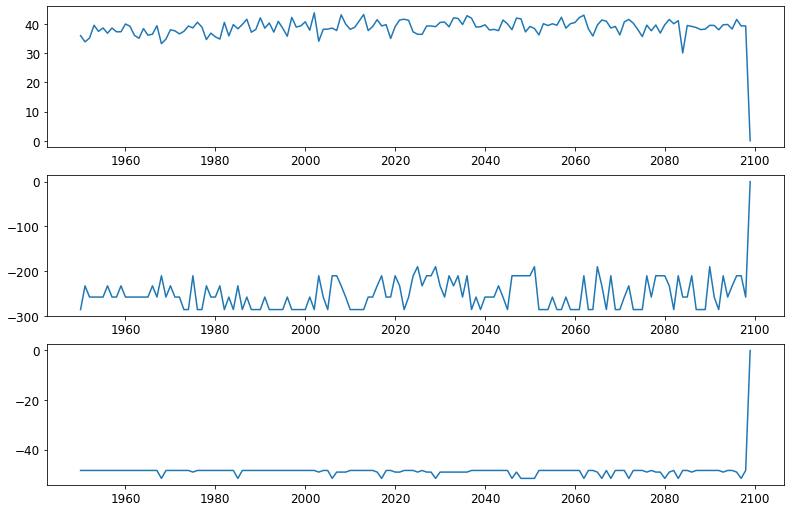

In [217]:
fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
mr
axs[0].plot(scen_1A.times, scen_1A.max_overturning)
axs[1].plot(scen_1A.times, scen_1A.max_overturning_d)
axs[2].plot(scen_1A.times, scen_1A.max_overturning_lat)

In [ ]:
print(scen_1A.max_overturning)